In [1]:
import math, random
import numpy as np
import pandas as pd
from collections import defaultdict
from helpers import *

In [2]:
# === CONFIG === #
N_SIM = 10000
ELO_SIGMA = 100.0   # scale of algorithmic ELO calculation
ALPHA = 1.0         # weight of ppg (points per game)
BETA = 0.8          # weight of gd_pg (goal diff per game)
GAMMA = 0.2         # weight of gf_pg (goals scored per game)
K_FACTOR = 20       # ELO update factor
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
# === Actual table status === #
teams_data = {
    "Fakel":        {"M":6, "W":5, "D":0, "L":1, "GF":25, "GA":12, "GD":13, "Pts":15},
    "Cyrkulatka":   {"M":6, "W":5, "D":0, "L":1, "GF":29, "GA":21, "GD":8,  "Pts":15},
    "EKO-RAFF":     {"M":5, "W":4, "D":0, "L":1, "GF":35, "GA":15, "GD":20, "Pts":12},
    "Banger W-wa":  {"M":6, "W":4, "D":0, "L":2, "GF":26, "GA":21, "GD":5,  "Pts":12},
    "Inferno Team": {"M":6, "W":3, "D":0, "L":3, "GF":27, "GA":26, "GD":1,  "Pts":9},
    "KPT Warszawa": {"M":6, "W":3, "D":0, "L":3, "GF":19, "GA":22, "GD":-3, "Pts":9},
    "Tune Squad":   {"M":6, "W":1, "D":1, "L":4, "GF":16, "GA":27, "GD":-11,"Pts":4},
    "CPI":          {"M":5, "W":1, "D":1, "L":3, "GF":15, "GA":30, "GD":-15,"Pts":3},
    "Blic Team":    {"M":6, "W":1, "D":0, "L":5, "GF":21, "GA":31, "GD":-10,"Pts":3},
    "Mitra":        {"M":6, "W":0, "D":2, "L":4, "GF":17, "GA":25, "GD":-8, "Pts":2}
}

teams = list(teams_data.keys())

In [4]:
# === Manual ELO ratings (optional) === #
manual_elo = {
    # "Fakel": 1560,
    # "Cyrkulatka": 1550,
    # ...
}
# If manual_elo is empty, an algorithmic way of calculating ELO will be used

In [5]:
# === Make sure to insert remaining matches below === #
remaining_matches = [
    ("Tune Squad","Inferno Team"), ("Mitra","EKO-RAFF"), ("Banger W-wa","CPI"), ("Fakel","Cyrkulatka"), ("KPT Warszawa","Blic Team"),
    ("EKO-RAFF","Banger W-wa"), ("Inferno Team","KPT Warszawa"), ("Blic Team","Mitra"), ("Cyrkulatka","Tune Squad"), ("CPI","Fakel"),
    ("CPI","EKO-RAFF"),
    ("Tune Squad","KPT Warszawa"), ("Fakel","EKO-RAFF"), ("Cyrkulatka","CPI"), ("Inferno Team","Mitra"),  ("Blic Team","Banger W-wa")
]

In [6]:
if manual_elo:
    elo0 = manual_elo.copy()
    # ensure all teams present
    for t in teams:
        if t not in elo0:
            elo0[t] = 1500
else:
    elo0 = compute_auto_elo(teams_data, alpha=ALPHA, beta=BETA, gamma=GAMMA, sigma=ELO_SIGMA)

draw_prob = estimate_draw_prob(teams_data)

print("Starting ELO:")
for t in teams:
    print(f"  {t:15s}: {elo0[t]}")

print(f"Estimated prob of draw from previous matches: {draw_prob:.3f}")
print(f"Number of simulations: {N_SIM}. Number of remaining matches: {len(remaining_matches)}")

Starting ELO:
  Fakel          : 1608
  Cyrkulatka     : 1587
  EKO-RAFF       : 1682
  Banger W-wa    : 1549
  Inferno Team   : 1510
  KPT Warszawa   : 1480
  Tune Squad     : 1403
  CPI            : 1367
  Blic Team      : 1408
  Mitra          : 1406
Estimated prob of draw from previous matches: 0.069
Number of simulations: 10000. Number of remaining matches: 16


In [7]:
# === SIMULATIONS === #
results_count = {t: np.zeros(len(teams)+1, dtype=int) for t in teams}  # positions 1..10 prep array
points_initial = {t: teams_data[t]["Pts"] for t in teams}
gd_initial = {t: teams_data[t]["GD"] for t in teams}
gf_initial = {t: teams_data[t]["GF"] for t in teams}
ga_initial = {t: teams_data[t]["GA"] for t in teams}
points_for_title = []
points_for_safety = []
match_outcomes = {
    pair: {"A_wins": 0, "Draws": 0, "B_wins": 0, "count": 0}
    for pair in remaining_matches
}

for sim in range(N_SIM):
    pts = points_initial.copy()
    gd = gd_initial.copy()
    gf = gf_initial.copy()
    ga = ga_initial.copy()
    elo = elo0.copy()

    for (a, b) in remaining_matches:
        pa, pdraw, pb = match_probs(elo0[a], elo0[b], draw_prob)
        r = random.random()
        if r < pa:  # A wins
            pts[a] += 3
            S_A, S_B = 1.0, 0.0
            match_outcomes[(a, b)]["A_wins"] += 1
        elif r < pa + pdraw:  # Draw
            pts[a] += 1
            pts[b] += 1
            S_A, S_B = 0.5, 0.5
            match_outcomes[(a, b)]["Draws"] += 1
        else:  # B wins
            pts[b] += 3
            S_A, S_B = 0.0, 1.0
            match_outcomes[(a, b)]["B_wins"] += 1

        match_outcomes[(a, b)]["count"] += 1
        elo[a], elo[b] = update_elo(elo[a], elo[b], S_A, S_B, K=K_FACTOR)

    # sorting by points, if tie: sort by GD -> GF -> GA
    items = list(pts.items())
    random.shuffle(items)   # shuffle to avoid bias in equal keys before sorting by tiebreakers
    items.sort(key=lambda x: (x[1]), reverse=True)

    points_for_title.append(items[0][1])   # store points for 1st place
    points_for_safety.append(items[7][1])  # store points for 8th place

    for pos, (team, p) in enumerate(items, start=1):
        results_count[team][pos] += 1

In [8]:
# === Remaining matches summary === #
records = []
for (a, b), s in match_outcomes.items():
    total = s["count"]
    if total > 0:
        records.append({
            "Team A": a,
            "A_win_%": s["A_wins"] / total * 100,
            "Draw_%":  s["Draws"] / total * 100,
            "B_win_%": s["B_wins"] / total * 100,
            "Team B": b
        })
df_wdl = pd.DataFrame(records).round(1)
display(df_wdl)

,Team A,A_win_%,Draw_%,B_win_%,Team B
0,Tune Squad,32.5,6.8,60.6,Inferno Team
1,Mitra,15.7,7.0,77.4,EKO-RAFF
2,Banger W-wa,67.8,7.3,25.0,CPI
3,Fakel,49.4,7.2,43.5,Cyrkulatka
4,KPT Warszawa,55.8,7.0,37.2,Blic Team
5,EKO-RAFF,63.1,7.1,29.8,Banger W-wa
6,Inferno Team,50.4,7.1,42.5,KPT Warszawa
7,Blic Team,46.6,6.8,46.6,Mitra
8,Cyrkulatka,69.8,6.8,23.4,Tune Squad
9,CPI,18.0,7.1,75.0,Fakel


In [9]:
# === RESULTS === #
prob_table = pd.DataFrame(index=teams, columns=[f"pos_{i}" for i in range(1, len(teams)+1)], dtype=float)
for t in teams:
    for pos in range(1, len(teams)+1):
        prob_table.loc[t, f"pos_{pos}"] = results_count[t][pos] / N_SIM

prob_table = prob_table.loc[sorted(teams, key=lambda x: -teams_data[x]["Pts"])]  # sort by current standings
pd.set_option("display.precision", 3)

# additionally: probs of top-3 and relegaiton (places 9 & 10)
summary = pd.DataFrame(index=teams, columns=["P_top3","P_relegation_9_10"])
for t in teams:
    summary.loc[t, "P_top3"] = prob_table.loc[t, ["pos_1","pos_2","pos_3"]].sum()
    summary.loc[t, "P_relegation_9_10"] = prob_table.loc[t, ["pos_9","pos_10"]].sum()

avg_points_title = np.mean(points_for_title)
avg_points_safety = np.mean(points_for_safety)
print(f"Average points needed for title: {avg_points_title:.2f}")
print(f"Average points needed to avoid relegation (8th place): {avg_points_safety:.2f}")

Average points needed for title: 22.73
Average points needed to avoid relegation (8th place): 6.76


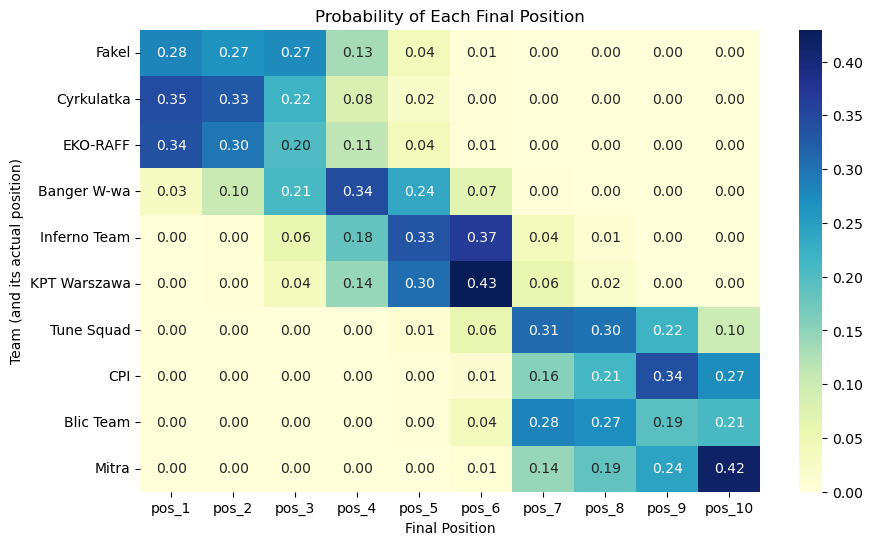

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(prob_table, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Probability of Each Final Position")
plt.xlabel("Final Position")
plt.ylabel("Team (and its actual position)")
plt.show()

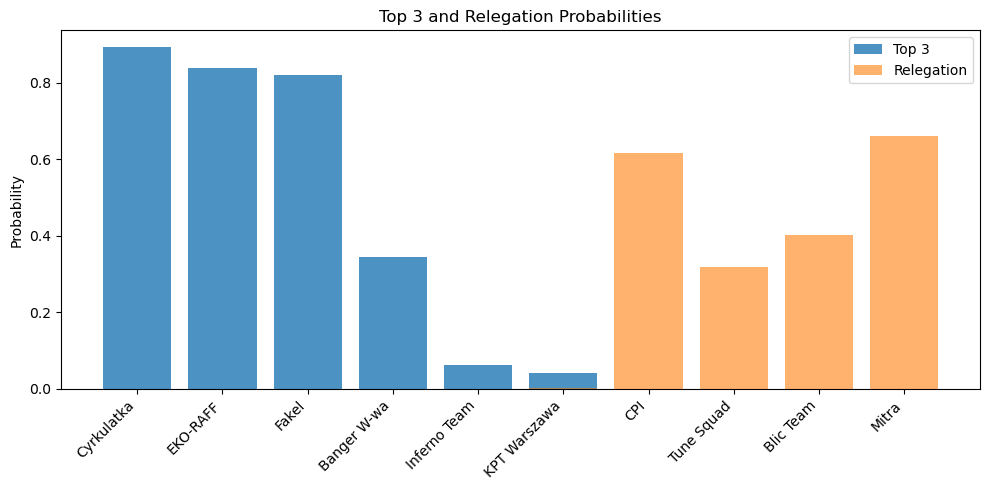

In [11]:
summary_sorted = summary.sort_values("P_top3", ascending=False)

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(summary_sorted.index, summary_sorted["P_top3"], label="Top 3", alpha=0.8)
ax.bar(summary_sorted.index, summary_sorted["P_relegation_9_10"], label="Relegation", alpha=0.6)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Probability")
plt.title("Top 3 and Relegation Probabilities")
plt.legend()
plt.tight_layout()
plt.show()


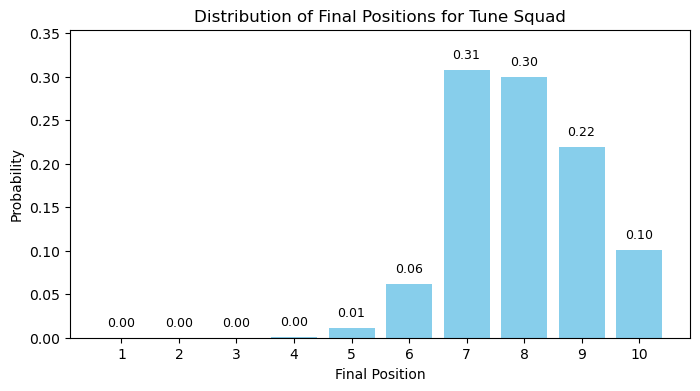

In [12]:
team = "Tune Squad"
positions = np.arange(1, len(teams) + 1)
probs = prob_table.loc[team]

plt.figure(figsize=(8,4))
bars = plt.bar(positions, probs, color="skyblue")

for bar, prob in zip(bars, probs):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{prob:.2f}', 
             ha='center', va='bottom', fontsize=9)

plt.ylim(0, max(probs)*1.15)

plt.xticks(positions)
plt.xlabel("Final Position")
plt.ylabel("Probability")
plt.title(f"Distribution of Final Positions for {team}")
plt.show()